# Import Statements

In [1]:
import tensorflow as tf
from keras.datasets import mnist
import cv2
import os
import pathlib
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

2025-12-04 06:23:36.653390: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-04 06:23:36.653465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-04 06:23:36.655164: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-04 06:23:36.666393: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read Dataset

In [2]:
import os
import cv2
import numpy as np
import pathlib

class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape

    def returnimagesaslist(self):
        self.images = []
        for label in self.labels:
            label_dir = os.path.join(self.datasetpath, label)
            image_files = list(pathlib.Path(label_dir).glob('*.[jJpP][pPnNgG]*'))
            self.images.append(image_files)

    def readImages(self):
        self.returnimagesaslist()
        self.finalImages = []
        labels = []

        for label_index in range(len(self.labels)):
            for img_path in self.images[label_index]:
                img = cv2.imread(str(img_path))
                if img is None:
                    print(f"Skipping: {img_path}")
                    continue

                try:
                    img = cv2.resize(img, self.image_shape)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = img / 255.0  # Normalize
                except Exception as e:
                    print(f"Error in {img_path}: {e}")
                    continue

                self.finalImages.append(img)
                labels.append(label_index)

        images = np.array(self.finalImages)
        labels = np.array(labels)

        print(f"Loaded {len(images)} images.")
        return images, labels


# VGG16 Architecture

In [3]:
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 3),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

2025-12-04 06:23:39.779283: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7507 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:08:00.0, compute capability: 6.1


In [4]:
# model_fake = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
# model_fake.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001))
# model_fake.summary()

In [5]:
model_real = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
model_real.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001))
model_real.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

# Real Dataset

## Reading Train, Test, Val

In [11]:
train_dataset = ReadDataset('chest_xray/chest_xray/train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
X_train, y_train = train_dataset.readImages()

Loaded 5216 images.


In [12]:
test_dataset = ReadDataset('chest_xray/chest_xray/test',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
X_test, y_test = test_dataset.readImages()

Loaded 624 images.


In [13]:
val_dataset = ReadDataset('chest_xray/chest_xray/val',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
X_val, y_val = val_dataset.readImages()

Loaded 16 images.


## Training

In [14]:
history = model_real.fit(
    X_train,
    y_train,
    epochs=60,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=2,
            monitor='val_loss',
            mode='min',
            restore_best_weights=True
        )
    ]
)

Epoch 1/60


2025-12-04 05:34:18.921283: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-12-04 05:34:22.454591: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff55074adf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-04 05:34:22.454653: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2025-12-04 05:34:22.465908: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764826462.623126 3348312 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 [==============================] - 21s 104ms/step - loss: 0.6714 - val_loss: 0.6925
Epoch 2/60
82/82 [==============================] - 6s 67ms/step - loss: 0.4101 - val_loss: 0.6901
Epoch 3/60
82/82 [==============================] - 6s 67ms/step - loss: 0.3182 - val_loss: 0.6830
Epoch 4/60
82/82 [==============================] - 6s 67ms/step - loss: 0.2771 - val_loss: 0.6593
Epoch 5/60
82/82 [==============================] - 6s 67ms/step - loss: 0.2481 - val_loss: 0.6765
Epoch 6/60
82/82 [==============================] - 6s 68ms/step - loss: 0.2285 - val_loss: 0.6708


## Results

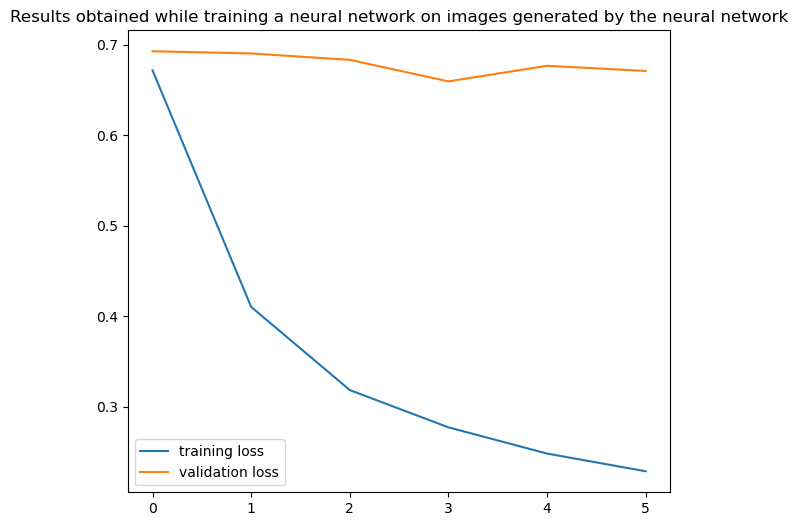

In [15]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [16]:
model_real.save("vgg_model_real_noclassbalance.h5")

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
model_real = tf.keras.models.load_model("vgg_model_real_noclassbalance.h5")

## Test on Real Dataset

In [18]:
model_real.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy']
)


In [19]:
model_real.evaluate(X_test, y_test)

20/20 [==============================] - 1s 13ms/step - loss: 0.6410 - accuracy: 0.7484


[0.6409605145454407, 0.7483974099159241]

In [22]:
y_pred = model_real.predict(X_test)

y_pred = (y_pred >= 0.5).astype("int32")

y_pred = y_pred.reshape(-1)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc * 100, "%")


20/20 [==============================] - 0s 11ms/step
Accuracy: 74.83974358974359 %


In [23]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.35      0.95      0.51        85
           1       0.99      0.72      0.83       539

    accuracy                           0.75       624
   macro avg       0.67      0.83      0.67       624
weighted avg       0.90      0.75      0.79       624



In [24]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, y_test)*100,
                                                                   recall_score(y_pred, y_test)*100,
                                                                   precision_score(y_pred, y_test)*100))

f1_score: 83.10010764262647, recall_score: 71.61410018552876, precision_score: 98.97435897435898


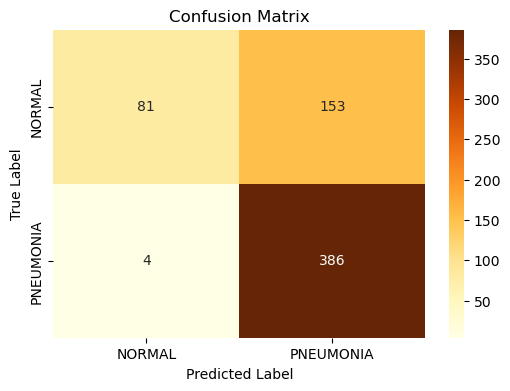

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix correctly
cm = confusion_matrix(y_test, y_pred)

# Convert to DataFrame
cm_df = pd.DataFrame(
    cm,
    index=['NORMAL', 'PNEUMONIA'],
    columns=['NORMAL', 'PNEUMONIA']
)

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlOrBr')
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


# Balanced Real Dataset - Downsampling

## Balancing

In [6]:
train_dataset = ReadDataset('chest_xray/chest_xray/train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
X_train, y_train = train_dataset.readImages()

Loaded 5216 images.


In [7]:
test_dataset = ReadDataset('chest_xray/chest_xray/test',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
X_test, y_test = test_dataset.readImages()

Loaded 624 images.


In [8]:
val_dataset = ReadDataset('chest_xray/chest_xray/val',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
X_val, y_val = val_dataset.readImages()

Loaded 16 images.


In [9]:
import numpy as np

def balance_split(X, y, random_state=42):
    np.random.seed(random_state)

    # find class counts
    idx_0 = np.where(y == 0)[0]
    idx_1 = np.where(y == 1)[0]

    # find minority size
    min_count = min(len(idx_0), len(idx_1))

    # sample equally
    idx_0_sampled = np.random.choice(idx_0, min_count, replace=False)
    idx_1_sampled = np.random.choice(idx_1, min_count, replace=False)

    # combine
    idx_balanced = np.concatenate([idx_0_sampled, idx_1_sampled])
    np.random.shuffle(idx_balanced)

    return X[idx_balanced], y[idx_balanced]


# --- Balance each split individually ---

X_train, y_train = balance_split(X_train, y_train)
X_val,   y_val   = balance_split(X_val,   y_val)
X_test,  y_test  = balance_split(X_test,  y_test)

from collections import Counter
print("Balanced Train:", Counter(y_train))
print("Balanced Val:  ", Counter(y_val))
print("Balanced Test: ", Counter(y_test))


Balanced Train: Counter({0: 1341, 1: 1341})
Balanced Val:   Counter({1: 8, 0: 8})
Balanced Test:  Counter({1: 234, 0: 234})


## Training

In [10]:
history = model_real.fit(
    X_train,
    y_train,
    epochs=60,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=2,
            monitor='val_loss',
            mode='min',
            restore_best_weights=True
        )
    ]
)

Epoch 1/60


2025-12-04 06:19:46.365500: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-12-04 06:19:49.794497: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fab8840ca60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-04 06:19:49.794565: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2025-12-04 06:19:49.806637: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764829189.950717 3354455 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 [==============================] - 19s 165ms/step - loss: 0.6927 - val_loss: 0.6925
Epoch 2/60
42/42 [==============================] - 3s 71ms/step - loss: 0.4130 - val_loss: 0.6910
Epoch 3/60
42/42 [==============================] - 3s 68ms/step - loss: 0.2788 - val_loss: 0.6889
Epoch 4/60
42/42 [==============================] - 3s 68ms/step - loss: 0.2322 - val_loss: 0.6862
Epoch 5/60
42/42 [==============================] - 3s 68ms/step - loss: 0.2017 - val_loss: 0.6809
Epoch 6/60
42/42 [==============================] - 3s 68ms/step - loss: 0.1849 - val_loss: 0.6741
Epoch 7/60
42/42 [==============================] - 3s 69ms/step - loss: 0.1676 - val_loss: 0.6592
Epoch 8/60
42/42 [==============================] - 3s 69ms/step - loss: 0.1758 - val_loss: 0.6436
Epoch 9/60
42/42 [==============================] - 3s 68ms/step - loss: 0.1540 - val_loss: 0.6334
Epoch 10/60
42/42 [==============================] - 3s 68ms/step - loss: 0.1488 - val_loss: 0.6175
Epoch 11/60
42/42 

## Results

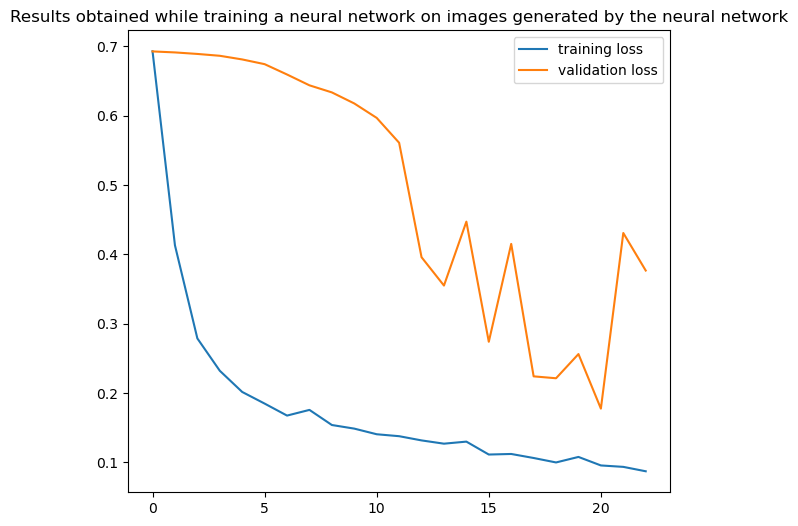

In [11]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [12]:
model_real.save("vgg_model_real_classbalance.h5")

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
model_real = tf.keras.models.load_model("vgg_model_real_classbalance.h5")

## Test on Real Dataset

In [14]:
model_real.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy']
)


In [15]:
model_real.evaluate(X_test, y_test)

15/15 [==============================] - 2s 64ms/step - loss: 0.4679 - accuracy: 0.7991


[0.46791619062423706, 0.7991452813148499]

In [16]:
y_pred = model_real.predict(X_test)

y_pred = (y_pred >= 0.5).astype("int32")

y_pred = y_pred.reshape(-1)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc * 100, "%")


15/15 [==============================] - 0s 10ms/step
Accuracy: 79.91452991452992 %


In [17]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.62      0.96      0.76       152
           1       0.97      0.72      0.83       316

    accuracy                           0.80       468
   macro avg       0.80      0.84      0.79       468
weighted avg       0.86      0.80      0.81       468



In [18]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, y_test)*100,
                                                                   recall_score(y_pred, y_test)*100,
                                                                   precision_score(y_pred, y_test)*100))

f1_score: 82.9090909090909, recall_score: 72.15189873417721, precision_score: 97.43589743589743


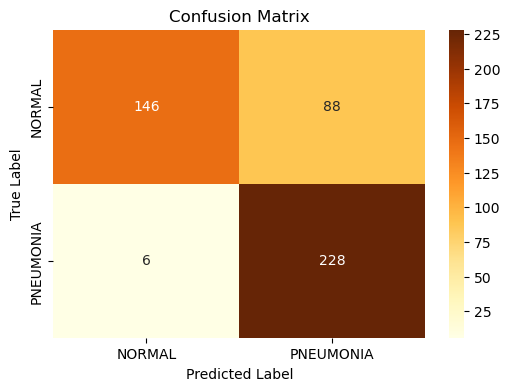

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix correctly
cm = confusion_matrix(y_test, y_pred)

# Convert to DataFrame
cm_df = pd.DataFrame(
    cm,
    index=['NORMAL', 'PNEUMONIA'],
    columns=['NORMAL', 'PNEUMONIA']
)

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlOrBr')
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


# Balancing - Upsampling

In [6]:
import numpy as np

def upsample_split(X, y, random_state=42):
    np.random.seed(random_state)

    idx_0 = np.where(y == 0)[0]   # NORMAL
    idx_1 = np.where(y == 1)[0]   # PNEUMONIA

    count_0 = len(idx_0)
    count_1 = len(idx_1)

    # Identify majority & minority
    if count_0 > count_1:
        majority_idx = idx_0
        minority_idx = idx_1
    else:
        majority_idx = idx_1
        minority_idx = idx_0

    # How many samples to add?
    samples_needed = len(majority_idx) - len(minority_idx)

    # Randomly upsample minority with replacement
    upsampled_idx = np.random.choice(minority_idx, samples_needed, replace=True)

    # Combine original + upsampled
    final_idx = np.concatenate([majority_idx, minority_idx, upsampled_idx])

    # Shuffle
    np.random.shuffle(final_idx)

    return X[final_idx], y[final_idx]


## Balancing

In [7]:
train_dataset = ReadDataset('chest_xray/chest_xray/train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
X_train, y_train = train_dataset.readImages()

Loaded 5216 images.


In [8]:
test_dataset = ReadDataset('chest_xray/chest_xray/test',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
X_test, y_test = test_dataset.readImages()

Loaded 624 images.


In [9]:
val_dataset = ReadDataset('chest_xray/chest_xray/val',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
X_val, y_val = val_dataset.readImages()

Loaded 16 images.


In [ ]:
import numpy as np

def upsample_split(X, y, random_state=42):
    np.random.seed(random_state)

    idx_0 = np.where(y == 0)[0]   # NORMAL
    idx_1 = np.where(y == 1)[0]   # PNEUMONIA

    count_0 = len(idx_0)
    count_1 = len(idx_1)

    # Identify majority & minority
    if count_0 > count_1:
        majority_idx = idx_0
        minority_idx = idx_1
    else:
        majority_idx = idx_1
        minority_idx = idx_0

    # How many samples to add?
    samples_needed = len(majority_idx) - len(minority_idx)

    # Randomly upsample minority with replacement
    upsampled_idx = np.random.choice(minority_idx, samples_needed, replace=True)

    # Combine original + upsampled
    final_idx = np.concatenate([majority_idx, minority_idx, upsampled_idx])

    # Shuffle
    np.random.shuffle(final_idx)

    return X[final_idx], y[final_idx]


In [11]:
X_train, y_train = upsample_split(X_train, y_train)
X_val,   y_val   = upsample_split(X_val, y_val)
X_test,  y_test  = upsample_split(X_test, y_test)
from collections import Counter
print("Balanced Train:", Counter(y_train))
print("Balanced Val:  ", Counter(y_val))
print("Balanced Test: ", Counter(y_test))

Balanced Train: Counter({1: 3875, 0: 3875})
Balanced Val:   Counter({1: 8, 0: 8})
Balanced Test:  Counter({0: 390, 1: 390})


## Training

In [12]:
history = model_real.fit(
    X_train,
    y_train,
    epochs=60,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=2,
            monitor='val_loss',
            mode='min',
            restore_best_weights=True
        )
    ]
)

Epoch 1/60


2025-12-04 06:27:08.935461: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-12-04 06:27:12.565579: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa44cb9cc90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-04 06:27:12.565637: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2025-12-04 06:27:12.579206: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764829632.722795 3357032 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


122/122 [==============================] - 23s 85ms/step - loss: 0.4826 - val_loss: 0.6898
Epoch 2/60
122/122 [==============================] - 8s 67ms/step - loss: 0.2151 - val_loss: 0.6779
Epoch 3/60
122/122 [==============================] - 8s 67ms/step - loss: 0.1705 - val_loss: 0.6370
Epoch 4/60
122/122 [==============================] - 8s 68ms/step - loss: 0.1541 - val_loss: 0.5409
Epoch 5/60
122/122 [==============================] - 8s 68ms/step - loss: 0.1353 - val_loss: 0.4681
Epoch 6/60
122/122 [==============================] - 8s 68ms/step - loss: 0.1219 - val_loss: 0.2619
Epoch 7/60
122/122 [==============================] - 8s 68ms/step - loss: 0.1154 - val_loss: 0.1979
Epoch 8/60
122/122 [==============================] - 8s 67ms/step - loss: 0.1073 - val_loss: 0.4819
Epoch 9/60
122/122 [==============================] - 8s 68ms/step - loss: 0.1020 - val_loss: 0.6612


## Results

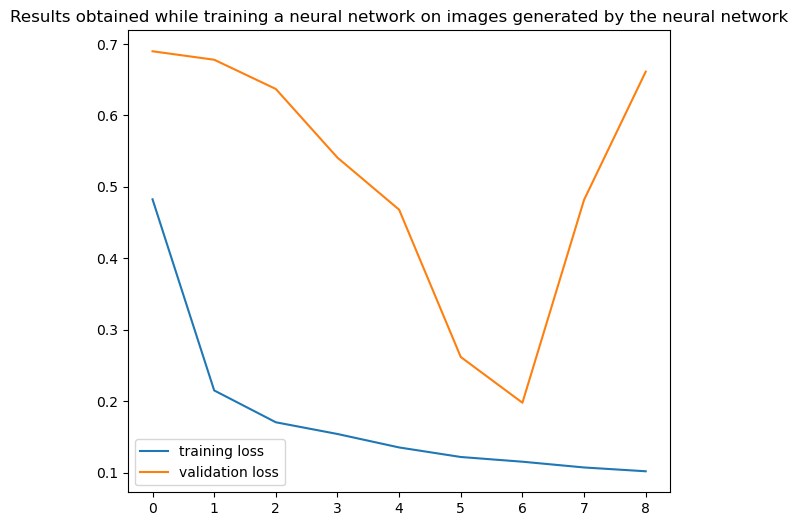

In [13]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [14]:
model_real.save("vgg_model_real_classbalance_upsample.h5")

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
model_real = tf.keras.models.load_model("vgg_model_real_classbalance_upsample.h5")

## Test on Real Dataset

In [17]:
model_real.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy']
)


In [18]:
model_real.evaluate(X_test, y_test)

25/25 [==============================] - 2s 38ms/step - loss: 0.3693 - accuracy: 0.8308


[0.36933740973472595, 0.8307692408561707]

In [19]:
y_pred = model_real.predict(X_test)

y_pred = (y_pred >= 0.5).astype("int32")

y_pred = y_pred.reshape(-1)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc * 100, "%")


25/25 [==============================] - 1s 10ms/step
Accuracy: 83.07692307692308 %


In [20]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.69      0.96      0.80       282
           1       0.97      0.76      0.85       498

    accuracy                           0.83       780
   macro avg       0.83      0.86      0.83       780
weighted avg       0.87      0.83      0.83       780



In [21]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, y_test)*100,
                                                                   recall_score(y_pred, y_test)*100,
                                                                   precision_score(y_pred, y_test)*100))

f1_score: 85.13513513513513, recall_score: 75.90361445783132, precision_score: 96.92307692307692


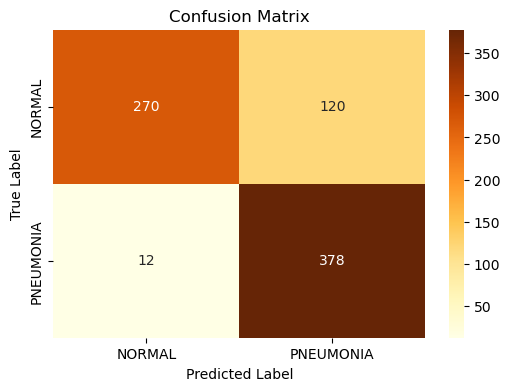

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix correctly
cm = confusion_matrix(y_test, y_pred)

# Convert to DataFrame
cm_df = pd.DataFrame(
    cm,
    index=['NORMAL', 'PNEUMONIA'],
    columns=['NORMAL', 'PNEUMONIA']
)

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlOrBr')
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
